Exploratory data analysis of the **IMDB 5000** dataset. <br>
The aim of this analysis is to extract useful features that can be used to predict the **IMDB score** of a movie before it has been released. <br>
This EDA is inspired from the following [one](https://www.kaggle.com/luisblanche/d/deepmatrix/imdb-5000-movie-dataset/predicting-imdb-rating).

In [9]:
# -*- coding: utf-8 -*-

In [79]:
# Data analysis libraries
import pandas as pd
import missingno as msno
import pandas_profiling as pdp
import numpy as np

# Plotting libraries
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline 

In [89]:
sns.set(font_scale=1.5)

# Load the dataset

In [15]:
imdb_df = pd.read_csv('movie_metadata.csv', encoding='UTF-8')

# Explore missing data

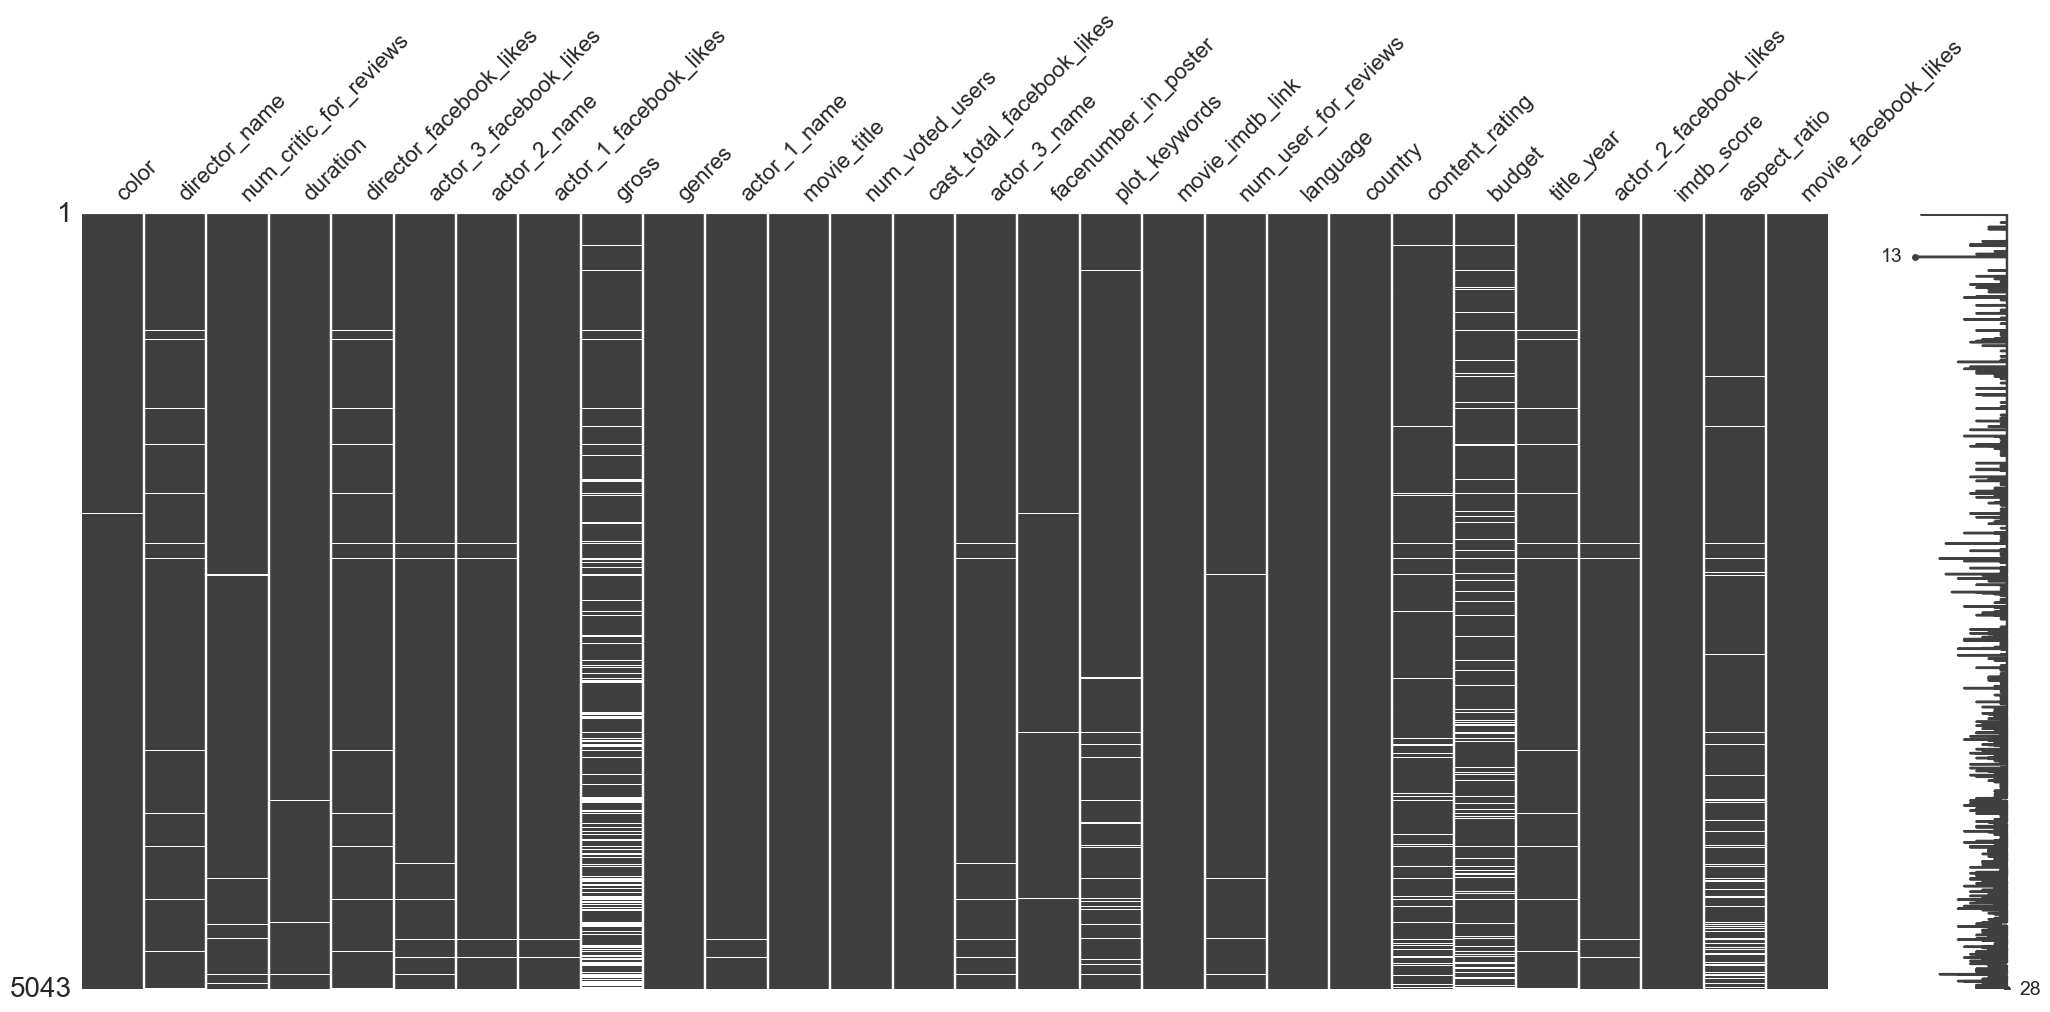

In [90]:
msno.matrix(imdb_df)

## Global dataset report

In [17]:
pdp.ProfileReport(imdb_df)

Number of variables,28
Number of observations,5043
Total Missing (%),1.9%
Total size in memory,1.1 MiB
Average record size in memory,224.0 B
Numeric,15
Categorical,12
Date,0
Text (Unique),0
Rejected,1
Distinct count,879


## Useless features 

The `aspect_ratio` and `movie_imdb_link` don't seem to have any predictive power on the `imdb_score`

In [106]:
useless_features = ["aspect_ratio", "movie_imdb_link"]

## Get numerical (and non-numerical) features 

In [129]:
numerical_features = imdb_df.columns[imdb_df.applymap(np.isreal).all()].tolist()

In [123]:
non_numerical_features = [col for col in imdb_df.columns if col not in numerical_features] 

=> The non_numerical_features are mainly categorical ones (except for `movie_title` and `plot_keywords` which
can be considered as text)

In [124]:
string_features=["movie_title", "plot_keywords"]
categorical_features=[i for i in non_numerical_features if i not in string_features]

In [130]:
numerical_features.remove("title_year")
categorical_features.append("title_year")

## Target correlation with numerical features 

In [74]:
imdb_df.corr().drop('imdb_score').loc[:, 'imdb_score'].sort_values()

title_year                  -0.209167
facenumber_in_poster        -0.062958
budget                       0.030688
actor_3_facebook_likes       0.052633
aspect_ratio                 0.059445
actor_1_facebook_likes       0.076099
actor_2_facebook_likes       0.083808
cast_total_facebook_likes    0.085787
director_facebook_likes      0.170802
gross                        0.198021
movie_facebook_likes         0.247049
duration                     0.261662
num_user_for_reviews         0.292475
num_critic_for_reviews       0.305303
num_voted_users              0.410965
Name: imdb_score, dtype: float64

## Features correlations

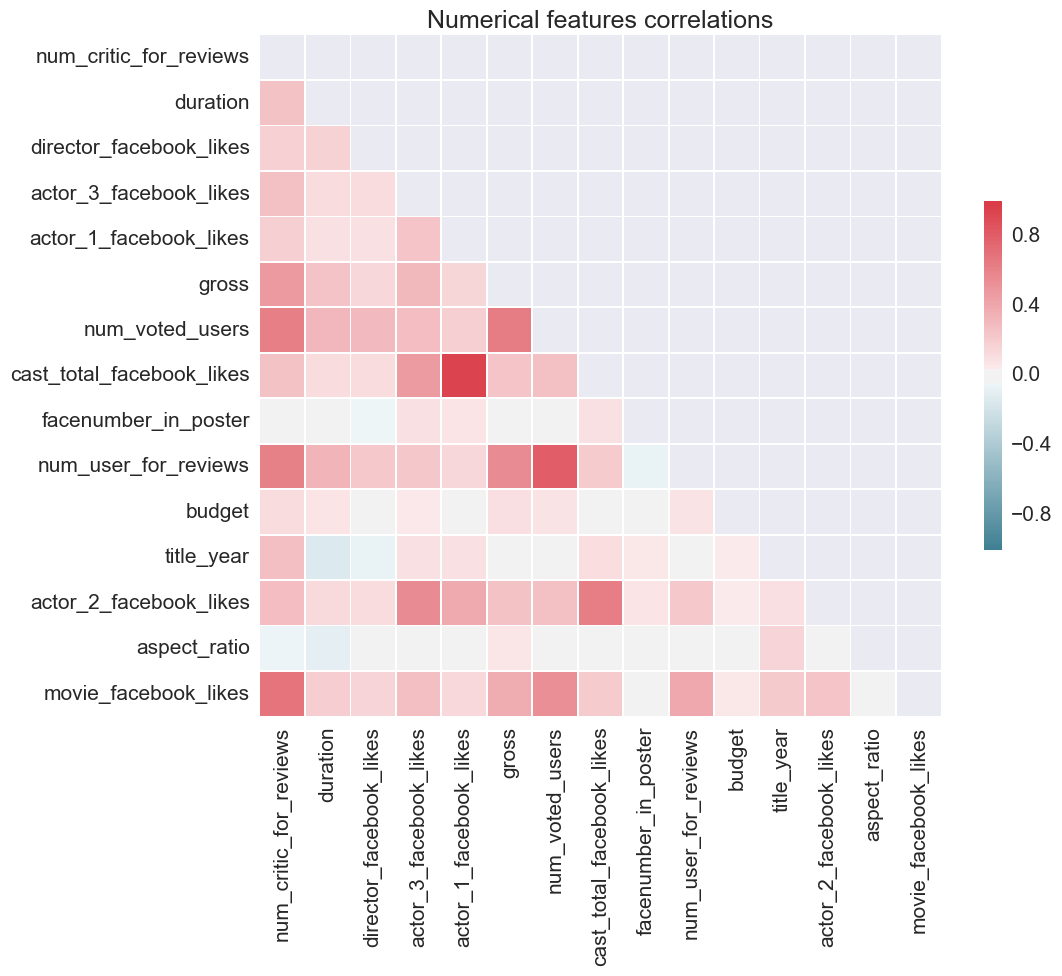

In [91]:
# Compute the correlation matrix
corr = imdb_df.drop('imdb_score', axis=1).corr()


# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
ax.set_title('Numerical features correlations')
#fig.savefig(BASE_PATH_FIGURES + add_creation_date() + '-correlation_heatmap.png')

In [59]:
imdb_df[['actor_1_facebook_likes', 'cast_total_facebook_likes']].corr()

,actor_1_facebook_likes,cast_total_facebook_likes
actor_1_facebook_likes,1.000000,0.951661
cast_total_facebook_likes,0.951661,1.000000


=> Drop the `cast_total_facebook_likes` feature since it is the sum of the different actors facebook likes

In [144]:
highly_correltaed_features = ['cast_total_facebook_likes']

## Afterwards features

Since the task is to predict the `imdb_score` before the release of the movie, it is necessary to drop the features
that are collected afterwards (such as `gross` for example). 

In [113]:
afterwards_features = ['gross', 'movie_facebook_likes', 'num_critic_for_reviews', 
                       'num_voted_users', 
                       'num_user_for_reviews']

## Target exploration 

In [98]:
imdb_df.imdb_score.describe()

count    5043.000000
mean        6.442138
std         1.125116
min         1.600000
25%         5.800000
50%         6.600000
75%         7.200000
max         9.500000
Name: imdb_score, dtype: float64

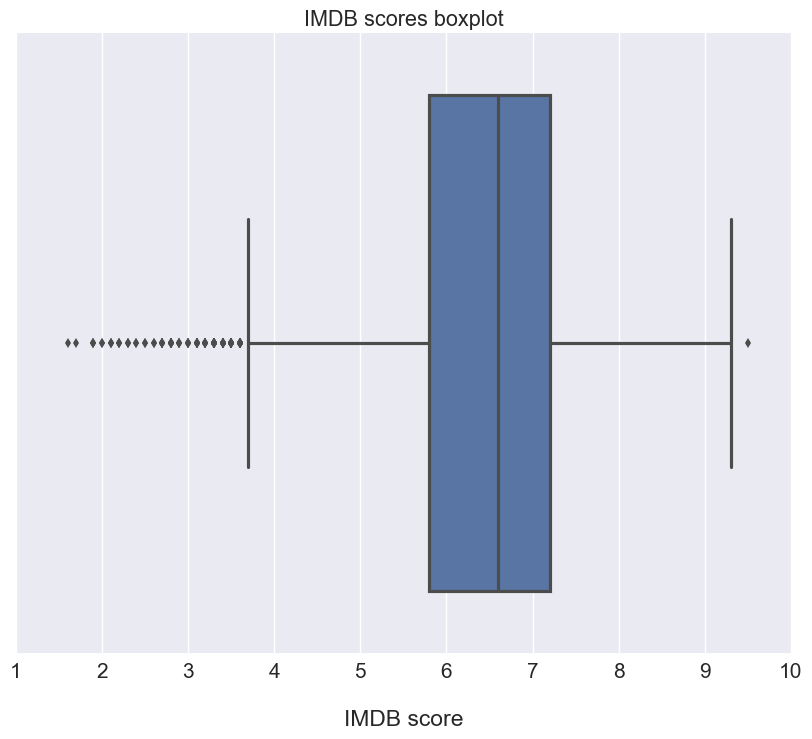

In [204]:
fig, ax = plt.subplots(1,1, figsize=(10, 8))
with sns.plotting_context('talk'):
    sns.boxplot(imdb_df.imdb_score, ax=ax)
    ax.set_xlabel('IMDB score')
    ax.set_title('IMDB scores boxplot')
    ax.xaxis.labelpad = 20

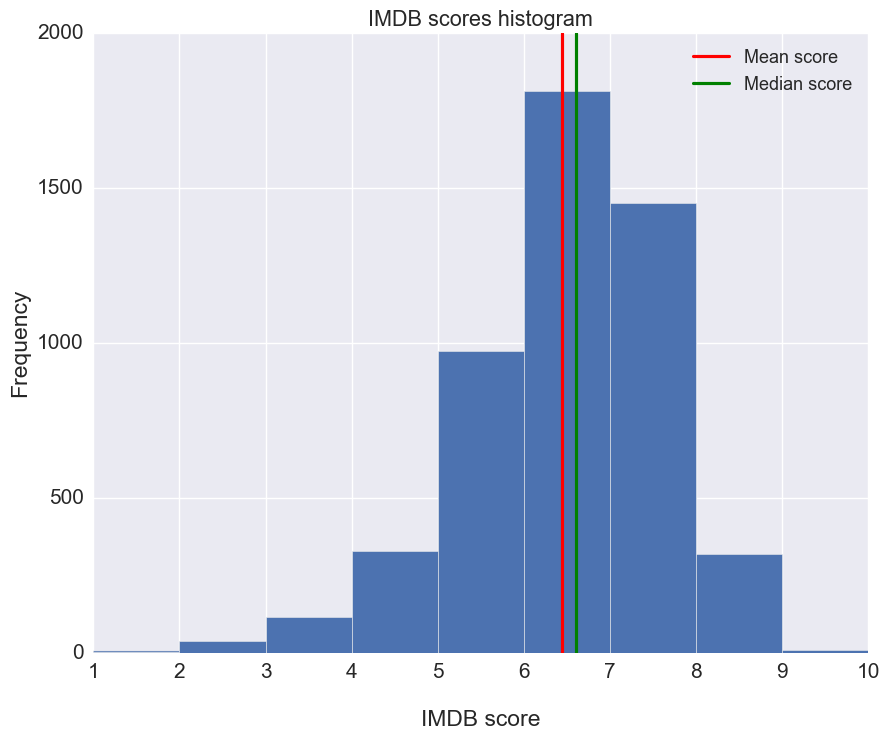

In [201]:
fig, ax = plt.subplots(1,1, figsize=(10, 8))

with sns.plotting_context('talk'):
    imdb_df.imdb_score.hist(ax=ax, bins=xrange(1,11,1))
    ax.axvline(imdb_df.imdb_score.mean(), color='red', label='Mean score')
    ax.axvline(imdb_df.imdb_score.median(), color='green', label='Median score')
    ax.legend()
    ax.set_xlabel('IMDB score')
    ax.set_ylabel('Frequency')
    ax.set_title('IMDB scores histogram')
    ax.xaxis.labelpad = 20

## Selected features 

In [172]:
removed_features = afterwards_features + useless_features + highly_correltaed_features

In [173]:
filtered_numerical_features = [col for col in numerical_features if col not in removed_features]

In [174]:
filtered_categorical_features = [col for col in categorical_features if col not in removed_features]

## Bar plot

In [194]:
def features_types():
    features_dict = dict(Categorical=len(filtered_categorical_features),
                         Numerical=len(filtered_numerical_features),
                         Removed=len(removed_features),
                         String=len(string_features)
        )
    return pd.DataFrame(features_dict, index=[1]).T

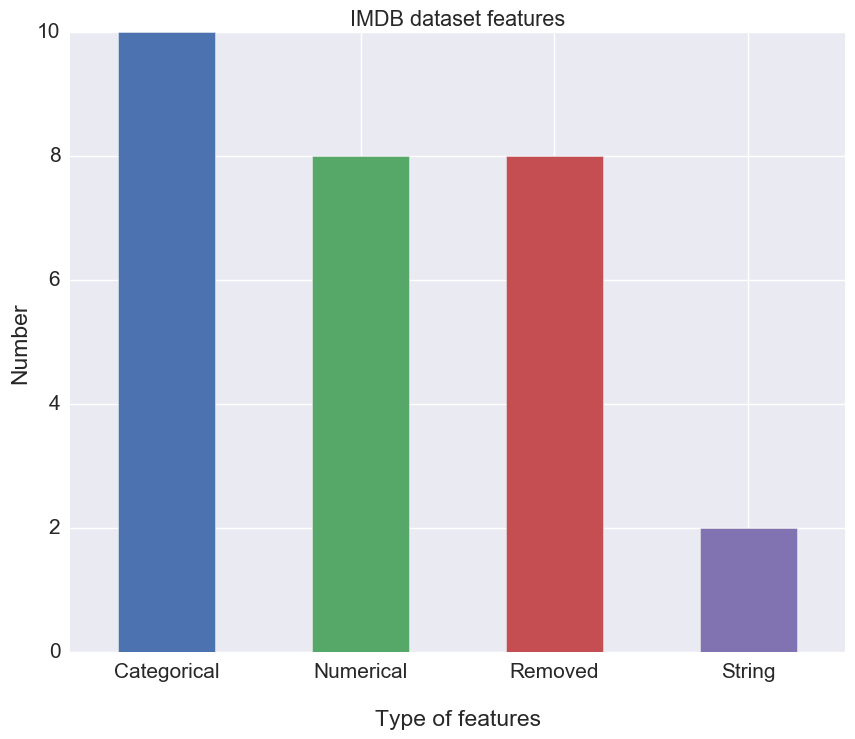

In [200]:
fig, ax = plt.subplots(1,1, figsize=(10, 8))

with sns.plotting_context('talk'):
    features_types().plot.bar(ax=ax, color=sns.color_palette(), rot=0)
    ax.legend('')
    ax.set_xlabel('Type of features')
    ax.set_ylabel('Number')
    ax.set_title('IMDB dataset features')
    ax.xaxis.labelpad = 20